In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import torch
import PIL
import healpy as hp
from earth2grid import healpix, latlon
import earth2grid


/home/stip-sac/nbelkhir/workspace/mirai/xp/cBottle/.conda/lib/python3.12/site-packages/earth2grid/healpix/core.py:60: UserWarning: healpixpad_cuda module not available, reverting to CPU for all padding routines
  warnings.warn("healpixpad_cuda module not available, reverting to CPU for all padding routines")


In [6]:
data = xr.open_dataset("../inference_output/0.nc")
data

<xarray.Dataset> Size: 9MB
Dimensions:   (crs: 1, time: 1, pix: 49152)
Coordinates:
  * crs       (crs) float32 4B 9.969e+36
  * time      (time) datetime64[ns] 8B 1940-01-01
Dimensions without coordinates: pix
Data variables: (12/45)
    U1000     (time, pix) float32 197kB ...
    U850      (time, pix) float32 197kB ...
    U700      (time, pix) float32 197kB ...
    U500      (time, pix) float32 197kB ...
    U300      (time, pix) float32 197kB ...
    U200      (time, pix) float32 197kB ...
    ...        ...
    rsut      (time, pix) float32 197kB ...
    pres_msl  (time, pix) float32 197kB ...
    pr        (time, pix) float32 197kB ...
    rsds      (time, pix) float32 197kB ...
    sst       (time, pix) float32 197kB ...
    sic       (time, pix) float32 197kB ...
Attributes:
    history:  scripts/inference_coarse.py --sample.min_samples 1 --dataset am...

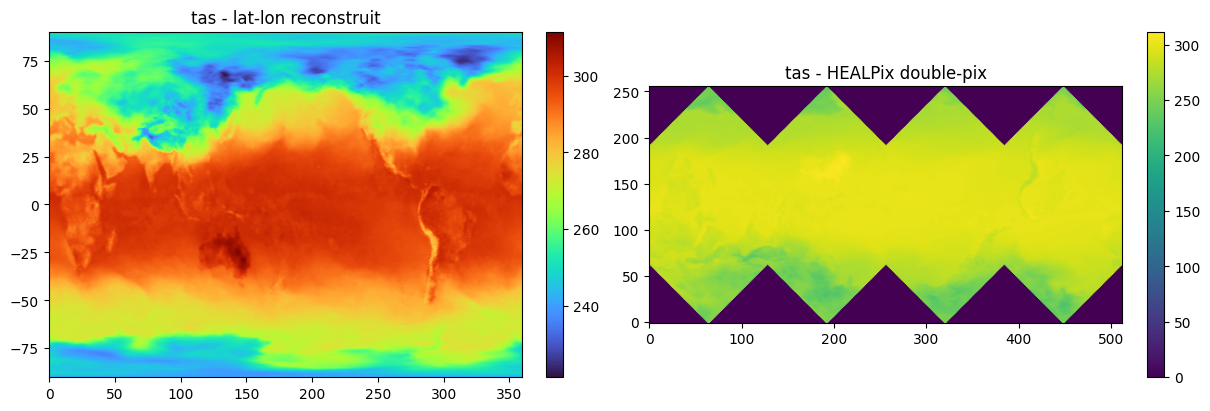

In [ ]:
var = "tas"                              # changez au besoin
hpx_field = data[var].isel(time=0).values           # (pix,)

nlat, nlon = 721, 1440
lat_tgt = np.linspace(-90, 90, nlat)
lon_tgt = np.linspace(0, 360, nlon, endpoint=False)
latlon_grid = latlon.LatLonGrid(lat=lat_tgt, lon=lon_tgt)

LEVEL = 6                               # nside = 64
hpx_grid = healpix.Grid(level=LEVEL, pixel_order=healpix.PixelOrder.RING)

regrid_hpx2ll = earth2grid.get_regridder(hpx_grid, latlon_grid).float()
if torch.cuda.is_available():
    regrid_hpx2ll = regrid_hpx2ll.cuda()

tensor_in = torch.from_numpy(hpx_field.astype(np.float32))
if torch.cuda.is_available():
    tensor_in = tensor_in.cuda()

latlon_field = regrid_hpx2ll(tensor_in).cpu().numpy()  # (nlat, nlon)

hpx_img = healpix.to_double_pixelization(hpx_field)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4), constrained_layout=True)

pcm1 = ax1.pcolormesh(lon_tgt, lat_tgt, latlon_field, shading="auto", cmap="turbo")
ax1.set_title(f"{var} - lat-lon reconstruit"); plt.colorbar(pcm1, ax=ax1, fraction=0.045)

pcm2 = ax2.imshow(hpx_img, origin="lower", cmap="turbo")
ax2.set_title(f"{var} - HEALPix double-pix");   plt.colorbar(pcm2, ax=ax2, fraction=0.045)

plt.show()


In [10]:
# Select first 10 timesteps and save to new netCDF file
data_subset = data.isel(time=slice(0, 1))

# Save the subset to a new netCDF file
output_file = "../inference_output/subset.nc"
data_subset.to_netcdf(output_file)
print(f"Saved subset with {len(data_subset.time)} timesteps to {output_file}")


Saved subset with 1 timesteps to ../inference_output/subset.nc


In [ ]:
# Select variables of interest
vars_to_keep = [
    'cllvi', 'clivi', 'tas', 'uas', 'vas', 'rlut', 
    'rsut', 'pres_msl', 'pr', 'rsds', 'sst', 'sic','crs'
]

# Create subset with first timestep and selected variables
data_subset = data.isel(time=slice(0, 1))[vars_to_keep]

# Save the subset to a new netCDF file 
output_file = "../inference_output/subset_selected_vars.nc"
data_subset.to_netcdf(output_file)
print(f"Saved subset with {len(data_subset.time)} timesteps and {len(vars_to_keep)} variables to {output_file}")


Saved subset with 1 timesteps and 12 variables to ../inference_output/subset_selected_vars.nc
